In [1]:
import numpy as np
import pandas as pd

In [2]:
experiment = f'2'

df = pd.read_csv(f'results/{experiment}/processed_data_{experiment}.csv', index_col='Unnamed: 0')

df = df.loc[df.c12 == 0] if int(experiment[0]) == 2 else df
df = df[df.n_data <= 8] if int(experiment[0]) == 3 else df
#df = df.drop(columns=['time']) if int(experiment[0]) == 3 else df
if int(experiment[0]) == 2:
    df.loc[df.sigma_eta_off_diag == -1, 'sigma_eta_off_diag'] = df.sigma_eta_diag
if 'prior' in df.columns:
    df.loc[df.prior == True, 'model'] = df[df.prior == True].model + '_sparse'

# Dataframe experiment # ALL OF THIS: 7,8
if int(experiment[0]) > 5:
    acc_cols = [c[:-4] for c in df.columns if c.endswith('_acc')]
    num_repetitions = len(df)

    df = pd.concat([df, df, df])
    df = df.reset_index(drop=True)
    df['dataset'] = sorted(acc_cols * num_repetitions)
    df['accuracy'] = np.zeros(df.shape[0])
    for acc_col in acc_cols:
        df.loc[df.dataset == acc_col, 'accuracy'] = df.loc[df.dataset == acc_col, f"{acc_col}_acc"]

df

,model,accuracy,seed,c11,c12,c21,c22,sigma_eta_diag,sigma_eta_off_diag
0,ngc,1.0,1,0.8,0.0,0,0.8,0.01,0.00
1,ngc,1.0,101,0.8,0.0,0,0.8,0.01,0.00
2,ngc,1.0,33,0.8,0.0,0,0.8,0.01,0.00
3,ngc,1.0,12,0.8,0.0,0,0.8,0.01,0.00
4,ngc,1.0,0,0.8,0.0,0,0.8,0.01,0.00
...,...,...,...,...,...,...,...,...,...
150,tvar,0.5,1,0.8,0.0,0,0.8,0.02,0.02
151,tvar,0.5,101,0.8,0.0,0,0.8,0.02,0.02
152,tvar,0.5,33,0.8,0.0,0,0.8,0.02,0.02
153,tvar,0.5,12,0.8,0.0,0,0.8,0.02,0.02


In [3]:
addition = []
if experiment == '0':
    addition += ['trainset_size']
elif experiment == '1a':
    addition += ['c11', 'c22']
elif experiment == '1b':
    addition += ['c21']
elif experiment == '1c':
    addition += ['c12']
elif experiment == '1d':
    addition += ['c12', 'c21']
elif experiment == '2':
    addition += ['c11', 'c12', 'c21', 'sigma_eta_diag', 'sigma_eta_off_diag']
elif experiment == '3':
    addition += ['n_data']
elif experiment == '4':
    addition += ['sparsity']
elif experiment == '5':
    addition += ['c11', 'c12', 'c21', 'c22']
elif experiment == '7' or experiment == '8':
    addition += ['dataset']

groupby_columns = ['model'] + addition
df_mean = df.groupby(by=groupby_columns).mean().rename(columns={'accuracy':'acc_mean'})[['acc_mean']]
df_std = df.groupby(by=groupby_columns).std().rename(columns={'accuracy': 'acc_std'})[['acc_std']]
df_time = df.groupby(by=groupby_columns).std().rename(columns={'time': 'time'})[['time']]
df_results = pd.concat([df_mean, df_std, df_time], axis=1, join="inner").reset_index()#[['model', 'c11', 'acc_mean', 'acc_std']]
df_results

KeyError: "None of [Index(['time'], dtype='object')] are in the [columns]"

In [223]:
mean_acc = np.array([df_results[df_results.model==model]['acc_mean'] for model in list(set(df.model))])
std_acc = np.array([df_results[df_results.model==model]['acc_std'] for model in list(set(df.model))])

mean_acc.shape, std_acc.shape

((4, 8), (4, 8))

['nri', 'ngc0', 'ngc', 'tvar']


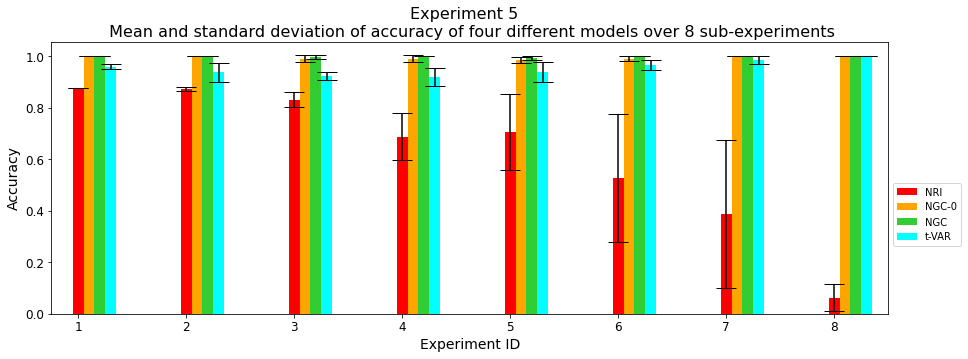

In [224]:
# Should I save figure?
save_figure = False

# Import the necessary libraries.
import matplotlib.pyplot as plt
import numpy as np

# create a figure with a width of 10 inches and a height of 8 inches
fig = plt.figure(figsize=(15, 5))

# Model name dictionary
model_names_dict = {
    'ngc': 'NGC',
    'ngc0': 'NGC-0',
    'nri': 'NRI',
    'tvar': 't-VAR',
    'nri_sparse': 'NRI(sparse prior)'
}
model_color_dict = {
    'ngc': 'limegreen',
    'ngc0': 'orange',
    'nri': 'red',
    'tvar': 'aqua',
    'nri_sparse': 'pink'
}

# Set the names of the four deep learning models.
model_names = list(set(df_results.model))
print(model_names)

# Set the number of hyperparameters for each model.
n_hyperparams = [int(len(df_results)/len(model_names))] * len(model_names)

# Set the mean accuracy and standard deviation of each hyperparameter for each model.
mean_accuracy = mean_acc
std_dev = std_acc

# Create the grouped bar chart.
for i, model_name in enumerate(model_names):
    x = np.arange(n_hyperparams[i]) + 1
    y = mean_accuracy[i]
    error = std_dev[i]
    plt.bar(x + i * 0.1, y, yerr=error, capsize=10, width=0.1, label=model_names_dict[model_name], color=model_color_dict[model_name])

# Set the x-axis limits.
plt.xlim(+0.75, n_hyperparams[0]+0.5)
plt.xticks(np.arange(n_hyperparams[0])+1, fontsize=12)
plt.yticks(fontsize=12)

# Set the y-axis limits.
#plt.ylim(0, 1)

# Set axis names
plt.ylabel('Similarity' if int(experiment[0]) >= 5 else 'Accuracy', fontsize=14)
plt.xlabel('Experiment ID', fontsize=14)
letter = '' if len(experiment) == 1 else f'({experiment[1]})'
sub = 0 if int(experiment[0]) < 7 else 1
plt.title(f'Experiment {int(experiment[0])+1-sub} {letter} \n Mean and standard deviation of accuracy of four different models over {n_hyperparams[0]} sub-experiments', fontsize=16)

# Add a legend.
plt.legend(bbox_to_anchor=(1.0, 0.5))

# Save figure
if save_figure:
    plt.savefig(f'results/{experiment}/results_{experiment}')

# Show the plot.
plt.show()

In [230]:
from datetime import datetime

datetime.strptime('2008-09-26T01:51:42.000Z', "%Y-%m-%dT%H:%M:%S.%fZ")

datetime.datetime(2008, 9, 26, 1, 51, 42)